# Guided Project: Predicting Listing Gains in the Indian IPO Market Using TensorFlow

### *Lu Yang*
### *06-18-2023*

Solution notebook can be referenced from [here](https://github.com/dataquestio/solutions/blob/master/Mission798Solutions.ipynb).

## Loading the Data

### Introduction

In this project, you'll work as a data scientist for an investment firm that is interested in investing in the Initial Public Offerings (IPO) in the Indian market. Your task is to build a deep learning classification model to determine if there will be listing gains for the IPO. Listing gains are the percentage increase in the share price of a company from its IPO issue price on the day of listing.

The dataset we'll be using for this project contains information on past IPOs in the Indian market and comes from [moneycontrol](https://www.moneycontrol.com/ipo/ipo-historic-table?classic=true).

We'll cover all the major steps of the modeling pipeline, starting with exploratory data analysis, then moving on to visualizing the important variables, then finally creating a deep learning classification model

### Data Dictionary

The dataset is available under the file name `Indian_IPO_Market_Data.csv` and consists of following columns:

- `Date`: date when the IPO was listed
- `IPOName`: name of the IPO
- `Issue_Size`: size of the IPO issue, in INR Crores
- `Subscription_QIB`: number of times the IPO was subscribed by the QIB (Qualified Institutional Buyer) investor category
- `Subscription_HNI`: number of times the IPO was subscribed by the HNI (High Networth Individual) investor category
- `Subscription_RII`: number of times the IPO was subscribed by the RII (Retail Individual Investors) investor category
- `Subscription_Total`: total number of times the IPO was subscribed overall
- `Issue_Price`: the price in INR at which the IPO was issued
- `Listing_Gains_Percent`: is the percentage gain in the listing price over the issue price

In [1]:
## load base libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [2]:
## load tensorflow.keras api

import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import Dense, Input
from keras.optimizers import SGD, RMSprop, Adam
from keras.wrappers.scikit_learn import KerasClassifier

2023-06-23 01:43:03.457504: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
ipo = pd.read_csv('Indian_IPO_Market_Data.csv')
ipo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   319 non-null    object 
 1   IPOName                319 non-null    object 
 2   Issue_Size             319 non-null    float64
 3   Subscription_QIB       319 non-null    float64
 4   Subscription_HNI       319 non-null    float64
 5   Subscription_RII       319 non-null    float64
 6   Subscription_Total     319 non-null    float64
 7   Issue_Price            319 non-null    int64  
 8   Listing_Gains_Percent  319 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 22.6+ KB


In [4]:
ipo.shape

(319, 9)

In [5]:
ipo.describe(include='all')

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
count,319,319,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
unique,287,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,16/08/21,Infinite Comp,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1192.859969,25.684138,70.091379,8.561599,27.447147,375.128527,4.742696
std,NaN,NaN,2384.643786,40.716782,142.454416,14.508670,48.772203,353.897614,47.650946
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-97.150000
25%,NaN,NaN,169.005000,1.150000,1.255000,1.275000,1.645000,119.000000,-11.555000
50%,NaN,NaN,496.250000,4.940000,5.070000,3.420000,4.930000,250.000000,1.810000
75%,NaN,NaN,1100.000000,34.635000,62.095000,8.605000,33.395000,536.000000,25.310000


In [6]:
ipo.isnull().sum() ## no missing value

Date                     0
IPOName                  0
Issue_Size               0
Subscription_QIB         0
Subscription_HNI         0
Subscription_RII         0
Subscription_Total       0
Issue_Price              0
Listing_Gains_Percent    0
dtype: int64

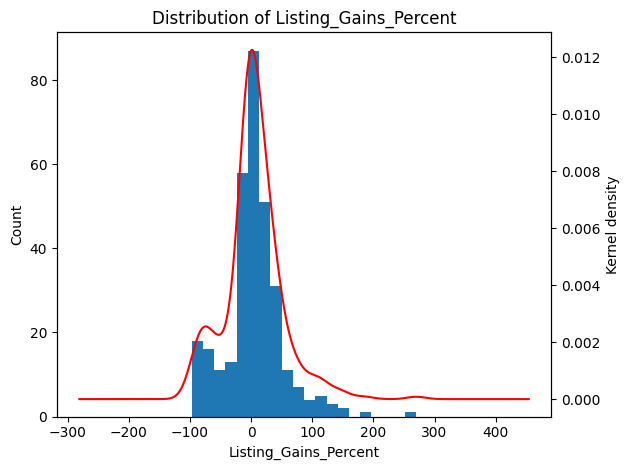

In [7]:
%matplotlib inline

fig, ax1 = plt.subplots()

ipo['Listing_Gains_Percent'].plot.hist(bins = 20, ax = ax1)
ax1.set_xlabel('Listing_Gains_Percent')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Listing_Gains_Percent')

ax2 = ax1.twinx()
ipo['Listing_Gains_Percent'].plot.kde(ax = ax2, color = 'red')
ax2.set_ylabel('Kernel density')

plt.tight_layout()

## Exploring the Data

Create a categorical target variable, `Listing_Gains_Profit`, which takes the binary values 1 when `Listing_Gains_Percent` is positive and 0 otherwise.

In [8]:
ipo['Listing_Gains_Profit'] = ipo['Listing_Gains_Percent'].apply(
lambda x: 1 if x > 0 else 0)

ipo['Listing_Gains_Profit'].value_counts()

1    174
0    145
Name: Listing_Gains_Profit, dtype: int64

In [9]:
ipo['Listing_Gains_Profit'].value_counts(normalize = True)

1    0.545455
0    0.454545
Name: Listing_Gains_Profit, dtype: float64

Considering the target of the model, clearly the `Date` and `IPOName` of the IPO were not relevant for our prediction. As we have transformed the problem into a classification type with the variable ` Listing_Gains_Profit`, the original target variable ` Listing_Gains_Percent` can be removed as well. 

In [10]:
ipo.drop(['Date ', 'IPOName', 'Listing_Gains_Percent'], axis = 1, inplace = True)

In [11]:
ipo.columns

Index(['Issue_Size', 'Subscription_QIB', 'Subscription_HNI',
       'Subscription_RII', 'Subscription_Total', 'Issue_Price',
       'Listing_Gains_Profit'],
      dtype='object')

## Data Visualization

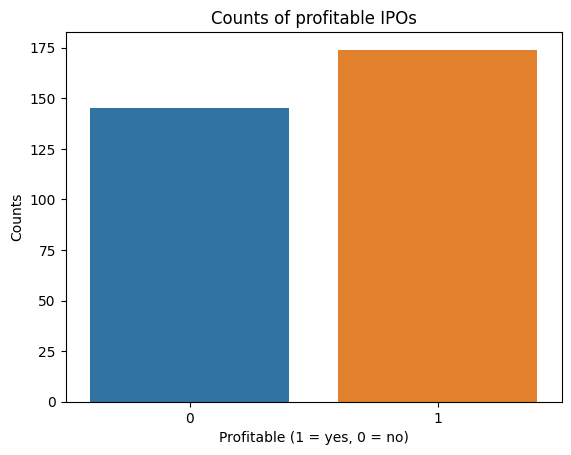

In [12]:
sns.countplot(ipo, x = 'Listing_Gains_Profit').set(
title = 'Counts of profitable IPOs', 
xlabel = 'Profitable (1 = yes, 0 = no)', 
ylabel = 'Counts')

plt.show()

In [13]:
features = list(set(ipo.columns) - set(['Listing_Gains_Profit']))
features

['Issue_Size',
 'Issue_Price',
 'Subscription_RII',
 'Subscription_Total',
 'Subscription_HNI',
 'Subscription_QIB']

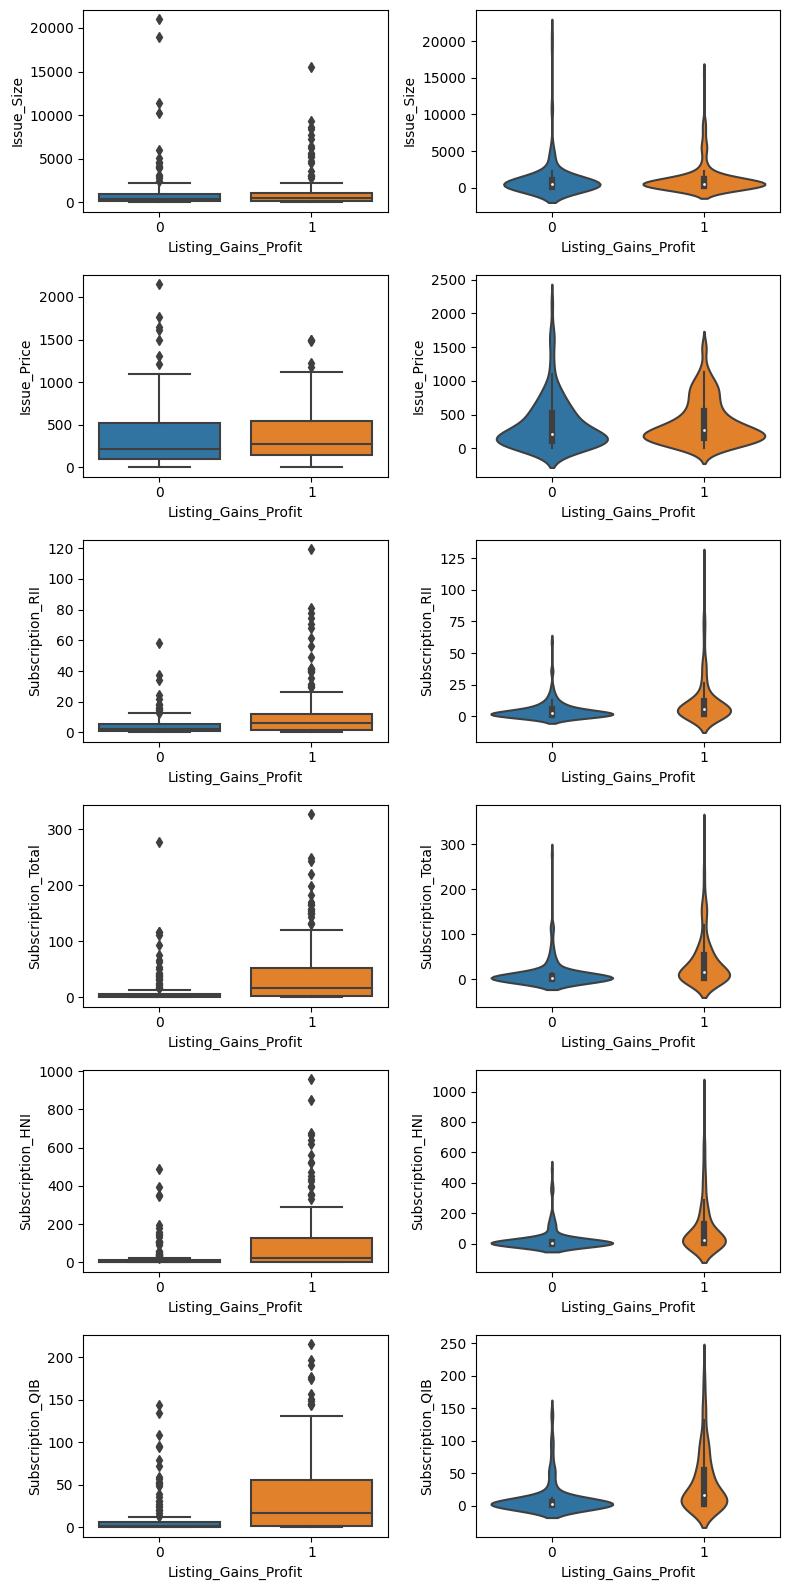

In [14]:
plt.figure(figsize = (8,16))

for i, feature in enumerate(features):
    

    plt.subplot(6,2,2*i+1)
    sns.boxplot(ipo, x = 'Listing_Gains_Profit', y = feature)
    
    plt.subplot(6,2,2*i+2)
    sns.violinplot(ipo, x = 'Listing_Gains_Profit', y = feature)

plt.tight_layout()

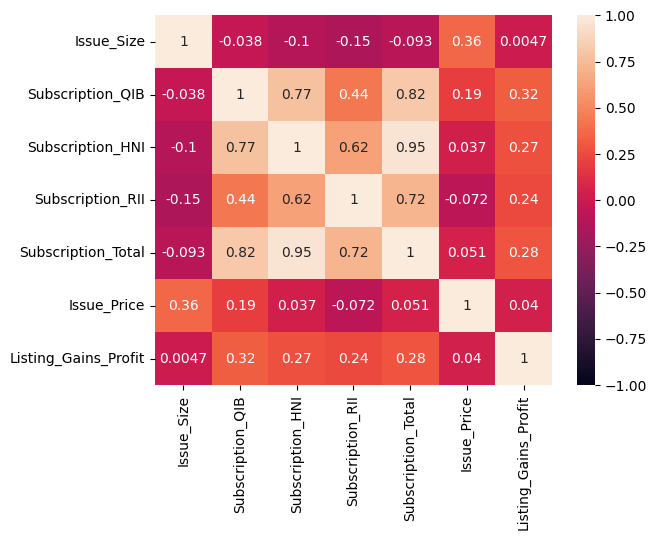

In [15]:
corrs = ipo.corr()
sns.heatmap(corrs, vmin = -1, vmax = 1, annot = True)

plt.show()

**The above visualizations indicated that**

* The `Subscription_Total` showed a strong positive correlation with all three individual subscription variables (`Subscription_QIB`, `Subscription_HNI` and `Subscription_RII`), which was expected. 
* The three individual subscription variables were also positively correlated with each other. 
* There was some minorly positive correlation between subscriptions and profitability (target).
* Outliers existed throughout all numerical features, whereas it seemed that they were more likely to appear in the IPOs that lost values (*i.e.*, `Listing_Gains_Profit` = 0)

##  Outlier Treatment

In [16]:
ipo[features].skew()

Issue_Size            4.853402
Issue_Price           1.696881
Subscription_RII      3.708274
Subscription_Total    2.911907
Subscription_HNI      3.078445
Subscription_QIB      2.143705
dtype: float64

In [17]:
def count_outlier_percentage(col):
    
    p75 = col.describe()['75%']
    p25 = col.describe()['25%']
    iqr = p75 - p25
    
    upper = p75 + 1.5*iqr
    lower = p25 - 1.5*iqr
    
    #print(p75, p25, iqr, upper, lower)
    
    num_of_outlier = sum((col > upper) | (col < lower))
    
    return num_of_outlier/len(col)*100


In [18]:
ipo[features].apply(count_outlier_percentage, axis = 0)  

Issue_Size            10.658307
Issue_Price            3.761755
Subscription_RII      10.344828
Subscription_Total     9.717868
Subscription_HNI      15.047022
Subscription_QIB      10.971787
dtype: float64

It appeared that the numerical features had somewhere ~ 4 - 15 % outliers, based on the *1.5IQR* criteria. We will be dealing with these outliers by replacing them into the corresponding upper or lower bound values.

In [19]:
def treat_outlier(col):
    
    p75 = col.describe()['75%']
    p25 = col.describe()['25%']
    iqr = p75 - p25
    
    upper = p75 + 1.5*iqr
    lower = p25 - 1.5*iqr
    
    
    col[col > upper] = upper
    col[col < lower] = lower
    
    return col

In [20]:
ipo[features] = ipo[features].apply(treat_outlier, axis = 0) 

In [21]:
ipo[features].apply(count_outlier_percentage, axis = 0) ## No more outliers present

Issue_Size            0.0
Issue_Price           0.0
Subscription_RII      0.0
Subscription_Total    0.0
Subscription_HNI      0.0
Subscription_QIB      0.0
dtype: float64

## Setting the Target and Predictor Variables

### Target Variable

In [22]:
y = ipo['Listing_Gains_Profit']
y.value_counts()

1    174
0    145
Name: Listing_Gains_Profit, dtype: int64

### Predictor Variable

In [23]:
X = ipo[features]
X.shape

(319, 6)

## Creating the Holdout Validation Approach

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
print(X_train.shape, X_test.shape)

(255, 6) (64, 6)


## Define the Deep Learning Classification Model

In [25]:
def create_model(learning_rate = 0.001, activation = 'relu'):
    
    inputs = Input(shape = (X_train.shape[1],))
    x = Dense(32, activation = activation)(inputs)
    x = Dense(16, activation = activation)(x)
    x = Dense(8, activation = activation)(x)
    x = Dense(4, activation = activation)(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    
    model = Model(inputs = inputs, outputs = outputs)
    
    model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], 
                 optimizer = Adam(learning_rate))
    
    return model

In [26]:
model = create_model(learning_rate = 0.01)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 32)                224       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params:

In [27]:
clf = KerasClassifier(build_fn = create_model, epochs = 200, batch_size = 32) ## use Sci-Keras later
clf

/tmp/ipykernel_7989/2119628629.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(build_fn = create_model, epochs = 200, batch_size = 32) ## use Sci-Keras later


In [28]:
pipeline = Pipeline([('scaler_minmax', MinMaxScaler()), 
                   ('nn_clf', clf)])
pipeline

Pipeline(steps=[('scaler_minmax', MinMaxScaler()),
                ('nn_clf',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f57e4fbd660>)])

## Compile and Train the model

### Initial experimentation

In [29]:
tf.keras.utils.set_random_seed(1)

pipeline.fit(X_train, y_train)

Epoch 1/200
8/8 [==============================] - 1s 3ms/step - loss: 0.6883 - accuracy: 0.5686
Epoch 2/200
8/8 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.5843
Epoch 3/200
8/8 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5882
Epoch 4/200
8/8 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.5686
Epoch 5/200
8/8 [==============================] - 0s 3ms/step - loss: 0.6681 - accuracy: 0.5490
Epoch 6/200
8/8 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.5373
Epoch 7/200
8/8 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.5373
Epoch 8/200
8/8 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.5529
Epoch 9/200
8/8 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.5686
Epoch 10/200
8/8 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6157
Epoch 11/200
8/8 [===========

Pipeline(steps=[('scaler_minmax', MinMaxScaler()),
                ('nn_clf',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f57e4fbd660>)])

In [30]:
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

2/2 [==============================] - 0s 2ms/step


In [31]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.66      0.76      0.70       119
           1       0.75      0.65      0.70       136

    accuracy                           0.70       255
   macro avg       0.71      0.71      0.70       255
weighted avg       0.71      0.70      0.70       255



In [32]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68        26
           1       0.78      0.82      0.79        38

    accuracy                           0.75        64
   macro avg       0.74      0.73      0.74        64
weighted avg       0.75      0.75      0.75        64



## Model Evaluation

### Hyperparameter tuning grid with cross validation

In [33]:
## Use a 5-fold cv

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

In [34]:
params = dict(
    nn_clf__learning_rate = [0.001, 0.01, 0.1],
    nn_clf__activation = ['relu', 'elu'], 
    nn_clf__batch_size = [16, 32],
    nn_clf__verbose = [0]
)

params

{'nn_clf__learning_rate': [0.001, 0.01, 0.1],
 'nn_clf__activation': ['relu', 'elu'],
 'nn_clf__batch_size': [16, 32],
 'nn_clf__verbose': [0]}

In [35]:
tf.keras.utils.set_random_seed(1)

hp_search = GridSearchCV(pipeline, params, cv = skf, return_train_score = True)
hp_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('scaler_minmax', MinMaxScaler()),
                                       ('nn_clf',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f57e4fbd660>)]),
             param_grid={'nn_clf__activation': ['relu', 'elu'],
                         'nn_clf__batch_size': [16, 32],
                         'nn_clf__learning_rate': [0.001, 0.01, 0.1],
                         'nn_clf__verbose': [0]},
             return_train_score=True)

In [36]:
print(hp_search.best_params_, hp_search.best_score_)

{'nn_clf__activation': 'elu', 'nn_clf__batch_size': 32, 'nn_clf__learning_rate': 0.001, 'nn_clf__verbose': 0} 0.6709821462631226


In [37]:
print(hp_search.cv_results_)

{'mean_fit_time': array([8.60371757, 8.54042153, 8.69219942, 4.70683651, 4.8195539 ,
       4.74040861, 8.63719616, 8.52202058, 8.57514024, 4.78044395,
       4.85914302, 4.82492537]), 'std_fit_time': array([0.68629199, 0.65572183, 0.80380282, 0.32241853, 0.4156164 ,
       0.32425888, 0.6847421 , 0.65343903, 0.64080906, 0.3314178 ,
       0.37475391, 0.3169966 ]), 'mean_score_time': array([0.1735929 , 0.17039714, 0.16766253, 0.16333275, 0.16714458,
       0.16226087, 0.17444773, 0.1684031 , 0.17331815, 0.16388869,
       0.26817718, 0.16385665]), 'std_score_time': array([0.01284676, 0.00646772, 0.00480676, 0.00354378, 0.00559003,
       0.00394264, 0.00940317, 0.00255578, 0.01032581, 0.0053635 ,
       0.18980361, 0.00480252]), 'param_nn_clf__activation': masked_array(data=['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'elu',
                   'elu', 'elu', 'elu', 'elu', 'elu'],
             mask=[False, False, False, False, False, False, False, False,
                   False, Fal